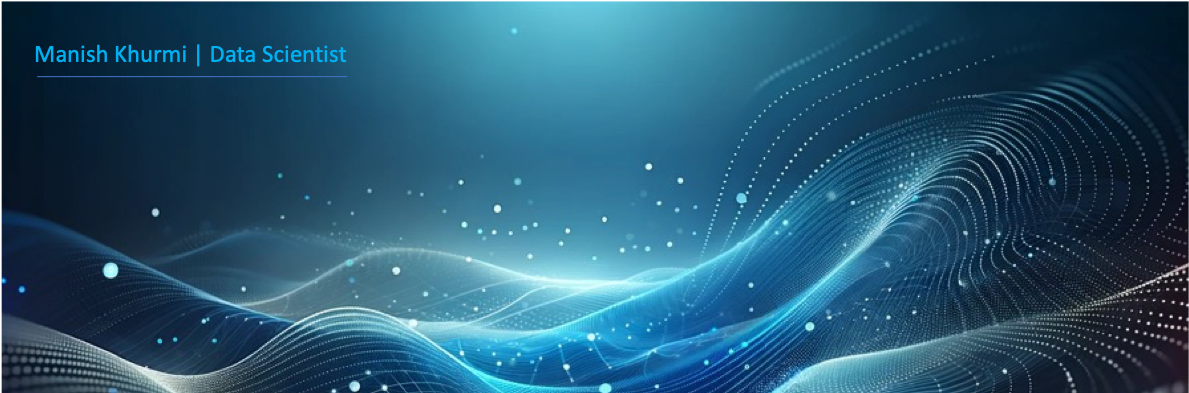

**Instructions**

Please click "Restart and Run All" on the Kernal and follow the first prompt for the file path. Thanks! 

# Abstract:
The project analyses JSON data exported from CAD software to identify the correct model among submissions and quantify the degree of incorrectness for others. The system aims to streamline the evaluation process and empower users with actionable insights to improve their CAD skills.

 ### CONTENTS
   
[Introduction](#intro)


[Section 1 : A Quantitative Comparison Report of 3D objects](#section_1)

- [Section 1.1 Identifying the Correct Model](#section_1.1)

- [Section 1.2: Quantifying Inaccuracy and Providing Feedback](#section_1.2)

[Section 2: Visualising the Problem using KNNs](#section_2)

[Section 3: Using PCA to solve for the Orientation Problem](#section_3)


<a id="intro"><a/>
# Introduction 

Proficiency in Computer-Aided Design (CAD) is fundamental for realising creative ideas in tangible form. Yet, assessing CAD model accuracy remains a persistent challenge. This project tackles this issue by creating an automated system that compares CAD models to predefined benchmarks and delivers actionable feedback. 

I want to use the ideas in this notebook as a foundation to provide a service for those teaching 3D modelling in AutoCAD. One version of the idea is that the Professors can upload their students models and get quantitative and qualitative report to help with their feedback to students. University professors spend on average 300 hours per semester grading these models, time they’d rather to allocate to one-to-one classroom feedback. My idea uses a  combination of a quantitative report based on machine learning algorithms and a large language model (LLM). 


---------------------------------------------

# Key Ideas

## 1. Using the First Prinicipal Component to find the orientation of an 3D object. 


- One significant challenge is assessing the orientation of students’ 3D models, crucial for identifying top performers. Treating the centroids of the faces as a data set rather than a 3D visual, allows us to leverage the first principal component of the data set as an orientation indiactor. 

Benefits: 
- Instant Feedback: The first Principal Components (PC1s) of the target 3D object can be generated and saved as a static data set, only the students PCs will have to be generated dynamically, if instant feedback is the route the Professor wants to go down i.e. up-on submission the student gets instant feedback. 
- The data sets are relatively small, computationally the PCA will be fast. This approach has the potential to be scalable, computationally efficent and easiy interpretable for both the professors and the LLM.

Current Limitations: 
- Time: I need approximately 3 weeks (full time) to complete the algorithm design and produce a report for University Professors. Further development such as overlaying the orinetatoin indicators to find the angle.
- Implementation challenges: deploying the quantitative report as a subscription model for AutoCAD or pay as you go report generation using an API. 

#### Next steps: 
- Calculate the angle between the Targets' orientation indicator and the Attempts' orientation indicator**

- Instead of random point generation for the density, create a lattice of equally spaced points, this will give homogenity when creating the orientation indicator for Target models.
- Create metrics around the KNN approach to add to the quantitative report.

## 2. Using bespoke metrics for the problem such as the Inverted Face Count Score. 

- The metrics have been created around the challenges that students face when modelling 3D objects. The metric mentioned rewards the students for creating an object with a similar number of faces to the Professors Target Model, it also brings into lower bounds which can be used to create intelligence on the students struggling most.

## 3. Combining the quantitative report with a Large Language Models


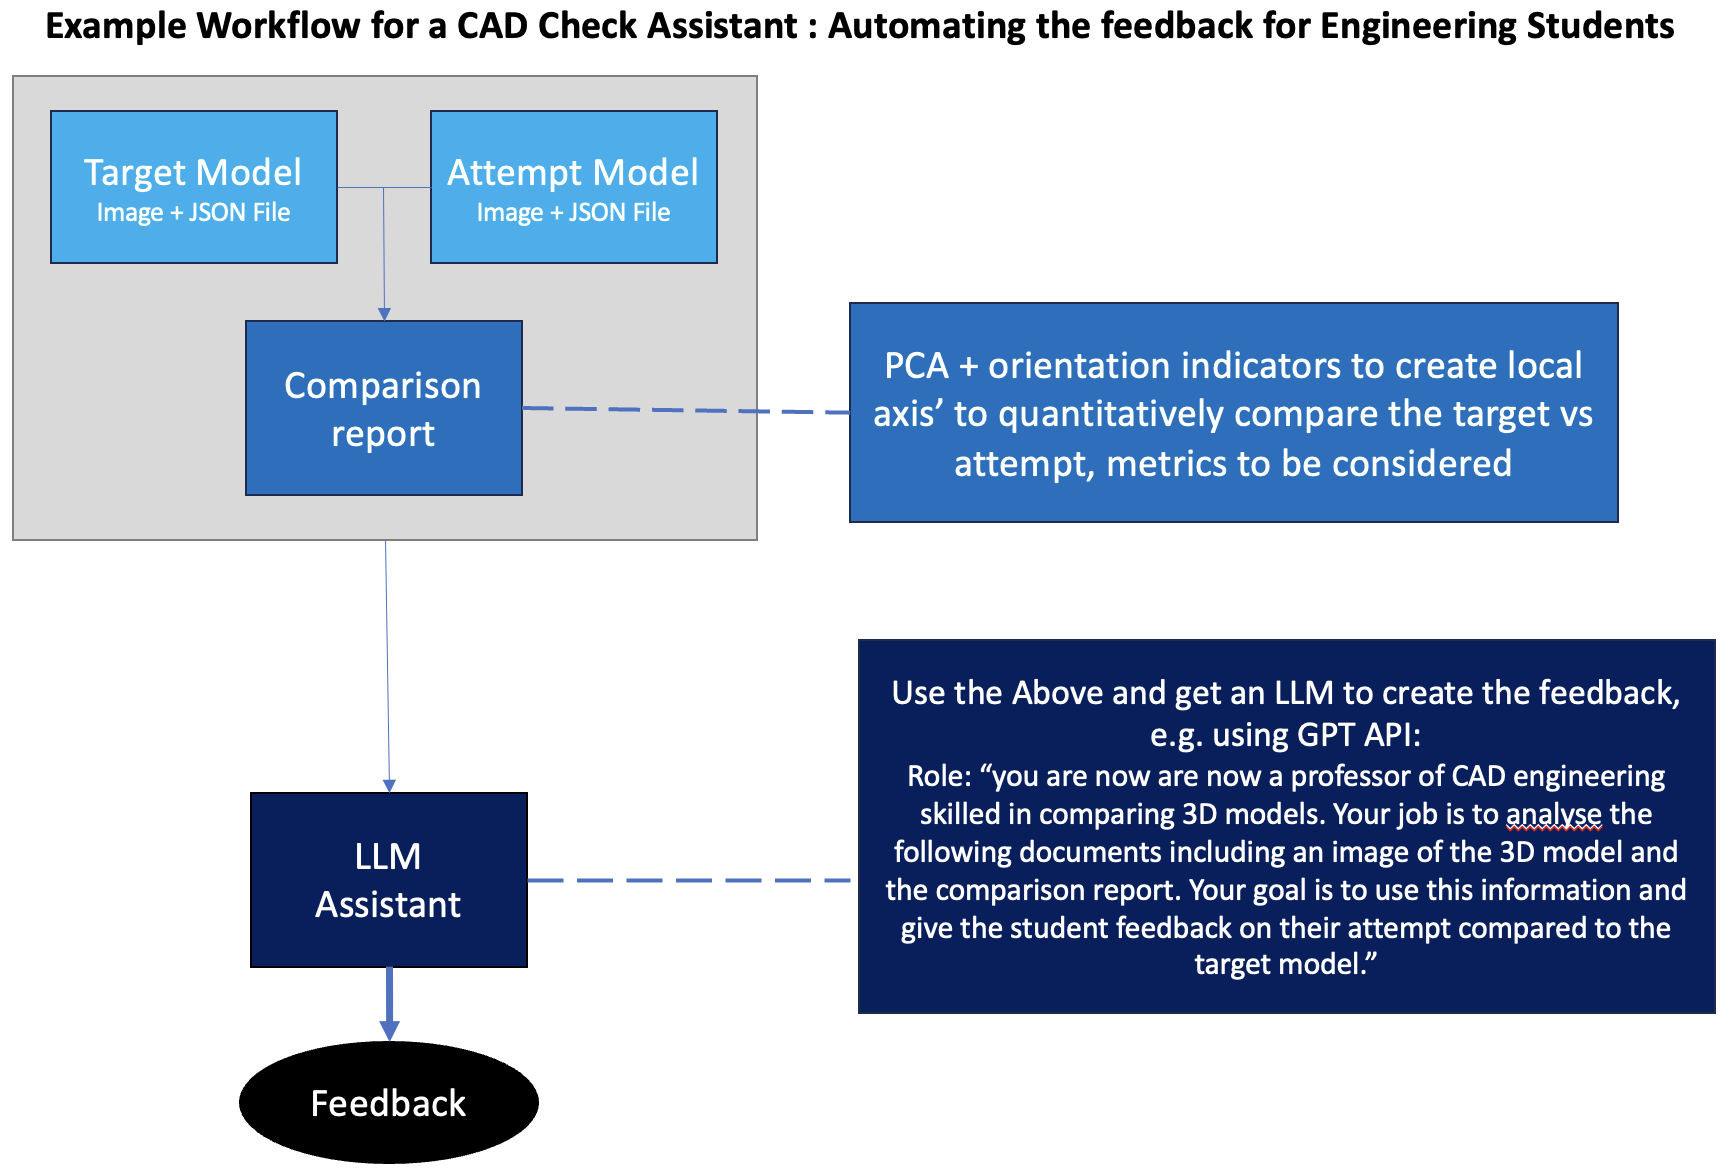

-----------------------------------------------

-----------------------------------------------

### Raw Data: JSON Files

**Volume**: This is a measure of how much space the entire CAD model occupies. Think of it as how much water it would displace if it were submerged in a pool. It's a single number representing the total volume.

**Bounding Box (bbMin and bbMax)**: Imagine drawing the smallest possible box around the entire model so that the model fits snugly inside it. The 'bbMin' and 'bbMax' values are the coordinates of the opposite corners of this imaginary box. 'bbMin' represents the corner with the lowest values (bottom-left-front corner), and 'bbMax' represents the corner with the highest values (top-right-back corner). This gives a rough idea of the model's overall size and position in space.

**Faces**: A CAD model is made up of flat surfaces called faces. Each face is like a single panel or surface of the model.

**Area of Faces**: Each face has an area, which is the amount of surface it covers. For example, think of it as the size of a flat piece of paper that makes up a part of a paper model.

**Centroid of Faces**: The centroid is the central point of a face. It's like the point where you could balance that face on the tip of a pencil. It tells you where each face is located in the model.

**Bounding Box of Faces (bbMin and bbMax)**: This is similar to the overall bounding box but for each individual face. It's the smallest box in which each face can fit, giving an idea of the size and position of each face within the model.

In summary, these files describe a CAD model by telling you its overall size (volume and bounding box), and detailed information about each surface (face) that makes up the model, including their size, position, and location in space. By comparing these details between the target model and the attempts, we can determine how similar they are.








In [1]:
# Libraries 
import json
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import cKDTree
from ipywidgets import widgets, interactive

### Load The Data

In [2]:
# Function to load JSON data from a file
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Ask the user to input the directory path
directory_path = input("Enter the directory path where the JSON files are located: ")

# File names are fixed
file_names = ["target.json", "attempt1.json", "attempt2.json", "attempt3.json", "attempt4.json"]

# Construct file paths
file_paths = {file_name.split('.')[0]: os.path.join(directory_path, file_name) for file_name in file_names}

# Loading data from all JSON files
data = {name: load_json_data(path) for name, path in file_paths.items()}

# For example for my path I use the following input:
    # /Users/manishkhurmi/Desktop/Fabrio - Smart Check by Manish

Enter the directory path where the JSON files are located: /Users/manishkhurmi/Desktop/Fabrio - Smart Check by Manish


In [3]:
# Loading data from all JSON files
data = {name: load_json_data(path) for name, path in file_paths.items()}

# Displaying the structure of the 'target.json' file
print("Structure of target model JSON:")
print(data['target'].keys())

Structure of target model JSON:
dict_keys(['volume', 'bbMin', 'bbMax', 'faces'])


<a id="section_1"><a/>
# Section 1 : A Quantitative Comparison Report of 3D objects.


The report will focus on the following
1. Establish which attempted CAD model is ‘correct’
2. For the remaining three ‘incorrect’ models:
    - Quantify how incorrect they are
    - Provide some feedback for the student to go with the above

<a id="section_1.1"><a/>
## Section 1.1 Identifying the Correct Model. 

## CAD Model Comparison Results

The final score for each attempt is calculated by summing these metrics, and the attempt with the lowest total score is considered the closest overall match to the target model. Below is the summarized result:

1. **Volume Difference (%)**: This represents how much the volume of each attempt deviates from the target model's volume. A lower percentage indicates a volume closer to that of the target model.
2. **Bounding Box Difference (%)**: This measures the difference in the bounding box dimensions between each attempt and the target model. Similar to volume, a lower percentage signifies a closer match to the target's bounding box dimensions.
3. **Inverted Face Count Score**: This score is inversely related to how close the number of faces in each attempt is to the target model's face count (targeted at 34 faces). A higher score here indicates a larger deviation from the target face count.

## Deep Dive: Inverted Face Count Score Equation

The Inverted Face Count Score is calculated using the following equation:

$$
\text{Inverted Face Count Score (%)} = \min\left(1, \frac{\lvert 34 - F_{\text{attempt}} \rvert}{\text{MaxDiff}}\right) \times 100
$$

- $F_{\text{attempt}}$ represents the number of faces in a given attempt.
- $\text{MaxDiff}$ is the maximum acceptable difference in the number of faces. In this context, it's set at 30 faces.

### Breakdown of the Equation

- **Maximum Acceptable Difference**: $\text{MaxDiff}$ of 30 faces implies that differences in the number of faces up to 30 are considered within an acceptable range. A difference larger than 30 will be capped in the score calculation.
- **Normalisation Factor**: $\text{MaxDiff}$ normalizes the score by setting the scale relative to the maximum acceptable difference.
- **Score Computation**: The absolute difference between the target face count (34 faces) and the attempt's face count is divided by $\text{MaxDiff}$. This ratio is then capped at 1, ensuring the score doesn’t exceed 100%.

### Interpretation of the Score

- If the absolute difference $\lvert 34 - F_{\text{attempt}} \rvert$ is less than or equal to 30, the ratio $\frac{\lvert 34 - F_{\text{attempt}} \rvert}{30}$ will be less than or equal to 1. This ratio, multiplied by 100, gives the percentage score.
- If the absolute difference is greater than 30, the score will be 100%, indicating a deviation of more than 30 faces from the target.
- A lower score indicates a face count closer to the target (34 faces), with 0% being an exact match.

In essence, $\text{MaxDiff}$ sets the upper limit for scoring deviations in face counts and standardizes the scoring system, making it easier to compare and understand the deviations.


In [4]:
# Function to calculate the inverted face score as a percentage
def calculate_inverted_face_score_percentage(faces_attempt, target_faces=34, max_diff=30):
    diff = abs(faces_attempt - target_faces)
    score = min(1, diff / max_diff) * 100  # Convert to percentage
    return score

#################################################################################################################################################################################
# Need more Explanation
# Function to compare volume, bounding box dimensions, and number of faces
def compare_models(target, attempt):
    volume_diff = abs(target['volume'] - attempt['volume']) / target['volume']
    bbox_diff = sum(abs(target['bbMin'][i] - attempt['bbMin'][i]) + abs(target['bbMax'][i] - attempt['bbMax'][i]) for i in range(3))   #These differences are summed up across all dimensions to provide a cumulative bounding box difference.
    faces_score = calculate_inverted_face_score_percentage(len(attempt['faces'])) 
    
    return volume_diff, bbox_diff, faces_score

# Comparing each attempt with the target
comparison_results = {name: compare_models(data['target'], data[name]) for name in ['attempt1', 'attempt2', 'attempt3', 'attempt4']}
#################################################################################################################################################################################

# Creating a DataFrame to display the comparison results
comparison_df = pd.DataFrame.from_dict(comparison_results, orient='index', columns=['Volume Difference', 'Bounding Box Difference', 'Inverted Face Count Score (%)'])

# Formatting the comparison DataFrame to show percentages
comparison_df_formatted = comparison_df.copy()
comparison_df_formatted['Volume Difference (%)'] = comparison_df_formatted['Volume Difference'] * 100  # Convert to percentage
comparison_df_formatted['Bounding Box Difference (%)'] = comparison_df_formatted['Bounding Box Difference'] * 100  # Convert to percentage

# Rounding the values for better readability
comparison_df_formatted = comparison_df_formatted.round(4)

# Drop the unformatted columns
comparison_df_formatted.drop(['Volume Difference', 'Bounding Box Difference'], axis=1, inplace=True)

# Find the attempt with the minimum sum across all columns
correct_attempt = comparison_df_formatted.sum(axis=1).idxmin()

# Print the final DataFrame 
print("Comparison Results:\n")
print(comparison_df_formatted.to_string())
print("\n" + "-" * 50)  # Adding a line separator
print(f"\nThe correct attempt is: {correct_attempt}")

Comparison Results:

          Inverted Face Count Score (%)  Volume Difference (%)  Bounding Box Difference (%)
attempt1                       100.0000                 0.0672                       0.0000
attempt2                        53.3333                 0.4340                       0.0000
attempt3                        60.0000                 4.9328                     100.0000
attempt4                         0.0000                 0.0000                       0.0001

--------------------------------------------------

The correct attempt is: attempt4


**Analysis:**
- Volume Difference: A lower value indicates that the volume of the attempt is closer to the target. Attempt 4 shows the smallest difference.
- Bounding Box Difference: A lower value suggests the overall size and position of the attempt are closer to the target. Again, Attempt 4 shows the smallest difference.
- Inverted Face Count Score (%): Attempt 4 has a value of 0, which means the number of faces is the same as the target (zero deviation from the target).
    
**Conclusion:**

**Attempt 4** is the most accurate recreation of the target model, as it closely matches in volume, bounding box dimensions, and the number of faces.


- With a larger Data Set, Machine Learning  could be used to predict the 'correctness' of a model based on features including the number of faces. 

<a id="section_1.2"><a/>
## Section 1.2: Quantifying Inaccuracy and Providing Feedback

For the remaining three models, I will calculate how much they deviate from the target in terms of volume, bounding box dimensions and number of faces, along with feedback based on these discrepancies.

**Identify the Incorrect Models**
- From Question 1, we determined that Attempt 4 is the most accurate. 
- The incorrect models are Attempt 1, Attempt 2, and Attempt 3.

### Normalized Scoring Function:

The normalized score for a particular metric is calculated using the formula:

$$
\text{Normalized Score} = 1 - \frac{|\text{Actual} - \text{Target}|}{\text{Max Difference}}
$$

Where:
- **Actual**: The actual value of the metric for an attempt.
- **Target**: The target value of the metric.
- **Max Difference**: The maximum absolute difference for the metric across all attempts.


### Composite Score Calculation:

The composite score for each attempt is the average of the individual normalized scores for volume, bounding box, and face count:

$$
\text{Composite Score} = \frac{\text{(30% * Volume Score)} + \text{(30% * BoundingBox Score)} + \text{(40% *Face Count Score)}}{3}
$$

- The Face Count Score is given a greater weighting. As the student is tasked with replicating the target model as closely as possible, the face count can be a clear indicator of accuracy. Deviations in face count might imply missing or extra features, which might be critical depending on the application.

### Volume, Bounding Box, and Face Count Scores:

For each metric, the score is calculated as follows:

- **Volume Score**:
  $$
  \text{Volume Score} = 1 - \frac{|V_{\text{attempt}} - V_{\text{target}}|}{\text{Max Volume Difference}}
  $$

- **Bounding Box Score** (average for each dimension):
  $$
  \text{BoundingBox Score} = \frac{1}{2} \times \left( \frac{1}{3} \sum_{i=1}^{3} \left( 1 - \frac{|\text{BB}_{\text{attempt},i} - \text{BB}_{\text{target},i}|}{\text{Max BoundingBox Difference}} \right) \right)
  $$

- **Face Count Score**:
  $$
  \text{Face Count Score} = 1 - \frac{|\text{Faces}_{\text{attempt}} - \text{Faces}_{\text{target}}|}{\text{Max Face Count Difference}}
  $$

### Example: Calculating Face Count Score

Consider:
- Target model faces: 100
- Attempt model faces: 120
- Maximum face count difference: 30

The face count score is calculated as:

$$
\text{Normalized Face Count Score} = 1 - \frac{|120 - 100|}{30} = 1 - \frac{20}{30} = \frac{1}{3} \approx 0.67
$$

This score of 0.67 indicates the attempt's relative closeness in face count to the target.

In [5]:
# Function to calculate normalized score based on absolute difference
def calculate_normalized_score(actual, target, max_diff):
    return 1 - abs(target - actual) / max_diff if max_diff != 0 else 1

#################################################################################################################################################################################
# Need more Explanation (Nearly all of it)

# Calculate max differences for normalization
max_volume_diff = max([abs(data['target']['volume'] - data[attempt]['volume']) for attempt in data if attempt != 'target'])
max_bbox_diff = max([abs(data['target']['bbMin'][i] - data[attempt]['bbMin'][i]) + abs(data['target']['bbMax'][i] - data[attempt]['bbMax'][i]) for i in range(3) for attempt in data if attempt != 'target'])
max_face_diff = max([abs(len(data['target']['faces']) - len(data[attempt]['faces'])) for attempt in data if attempt != 'target'])
#################################################################################################################################################################################

# Weights for composite score calculation
weights = {
    'volume': 0.3,  # 30% weight for Volume Score
    'bbox': 0.3,    # 30% weight for Bounding Box Score
    'faces': 0.4    # 40% weight for Face Count Score, as Deviations in face count might imply missing or extra features, which might be critical depending on the application
}

#################################################################################################################################################################################
# Need more Explanation

# Calculate scores for each attempt
scores = {}
for attempt in data:
    if attempt == 'target':
        continue

    volume_score = calculate_normalized_score(data[attempt]['volume'], data['target']['volume'], max_volume_diff)
    bbox_score = np.mean([calculate_normalized_score(data[attempt]['bbMin'][i], data['target']['bbMin'][i], max_bbox_diff) + calculate_normalized_score(data[attempt]['bbMax'][i], data['target']['bbMax'][i], max_bbox_diff) for i in range(3)]) / 2
    face_count_score = calculate_normalized_score(len(data[attempt]['faces']), len(data['target']['faces']), max_face_diff)

    # Composite score calculation with weights
    composite_score = (weights['volume'] * volume_score +
                       weights['bbox'] * bbox_score +
                       weights['faces'] * face_count_score)
    scores[attempt] = composite_score

# Rank the attempts based on composite score
ranked_attempts = sorted(scores.items(), key=lambda x: x[1], reverse=True)




# Provide feedback based on scores
feedback = {}
for attempt, score in ranked_attempts:
    feedback[attempt] = {
        'score': score,
        'feedback': f"Your model's score is {score:.2f}. " +
                    ("It closely matches the target model." if score > 0.8 else
                     "Consider reviewing the volume, bounding box dimensions, and number of faces for improvements.")
    }

# Displaying the results
for attempt, details in feedback.items():
    print(f"{attempt}: Score = {details['score']:.2f}, Feedback: {details['feedback']}")


attempt4: Score = 1.00, Feedback: Your model's score is 1.00. It closely matches the target model.
attempt2: Score = 0.94, Feedback: Your model's score is 0.94. It closely matches the target model.
attempt3: Score = 0.61, Feedback: Your model's score is 0.61. Consider reviewing the volume, bounding box dimensions, and number of faces for improvements.
attempt1: Score = 0.60, Feedback: Your model's score is 0.60. Consider reviewing the volume, bounding box dimensions, and number of faces for improvements.


**Analysis:**
- Attempt 1: The primary issue is the high number of faces compared to the target, leading to a high overall inaccuracy. The volume and bounding box are quite accurate.
- Attempt 2: While the volume and bounding box dimensions are close to the target, the number of faces is off, which affects the model's overall complexity.
- Attempt 3: This model requires significant adjustments in all areas: volume, bounding box, and face count.

**Additional Feedback:**

This is the kind of feedback I'd want a more sophisticated model to produce

- Attempt 1: Focus on simplifying the model by reducing the number of faces to match the target's complexity.
- Attempt 2: Minor adjustments are needed, primarily in matching the target's face count.
- Attempt 3: Comprehensive revisions are necessary, including resizing and reshaping the model, and aligning the number of faces with the target. ​

<a id="section_2"><a/>

# Section 2: Visualising the Problem

- Here we will look at 3D interactive plot of the Target Face Centroids and then a comparison plot of the Target vs attempts. The aim here is to see if we can gain any insights and possible areas for further research.

### The k-Nearest Neighbors (k-NN) 

- The k-Nearest Neighbors (k-NN) algorithm is a simple yet powerful method used in both classification and regression problems in machine learning. It's based on the principle of proximity or closeness, where the algorithm identifies the k closest data points to a given query point and makes predictions based on these points. Let's break down how it works:

- Choice of k: The choice of k is critical. A small value of k can make the algorithm sensitive to noise, while a large k makes it computationally expensive and might include points that are relatively far away, diluting the relevance of closer points.

In [6]:
#################################################################################################################################################################################
# Need more Explanation ( All of it)

# Function to load JSON data
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Function to extract centroids from model data
def extract_centroids(model_data):
    centroids = [face['centroid'] for face in model_data['faces']]
    return np.array(centroids)

# Function to find nearest neighbors
def find_nearest_neighbors(source_centroids, target_centroids):
    tree = cKDTree(target_centroids)
    distances, indices = tree.query(source_centroids, k=1)
    return distances, indices

# Function to create 3D scatter plot of centroids
def create_3d_scatter(centroids, color, name):
    scatter = go.Scatter3d(
        x=centroids[:, 0], y=centroids[:, 1], z=centroids[:, 2],
        mode='markers',
        marker=dict(size=4, color=color, opacity=0.8),
        name=name
    )
    return scatter

# Function to create lines representing nearest neighbors
def create_nearest_neighbor_lines(source, target, indices):
    lines = []
    for s, t in zip(source, target[indices]):
        lines.append(go.Scatter3d(
            x=[s[0], t[0]], y=[s[1], t[1]], z=[s[2], t[2]],
            mode='lines',
            line=dict(color='green', width=2),
            showlegend=False
        ))
    return lines

# Extract All Centroids 
centroids_target = extract_centroids(data['target'])

# Function to update plot based on selected attempt
def update_plot(attempt):
    fig.data = []
    attempt_data = data[attempt]

    # Add target centroids
    fig.add_trace(create_3d_scatter(centroids_target, 'blue', 'Target'))

    # Add attempt centroids
    centroids_attempt = extract_centroids(attempt_data)
    fig.add_trace(create_3d_scatter(centroids_attempt, 'blue', attempt))

    # Calculate and add nearest neighbor lines
    _, indices = find_nearest_neighbors(centroids_attempt, centroids_target)
    for line in create_nearest_neighbor_lines(centroids_attempt, centroids_target, indices):
        fig.add_trace(line)

# Dropdown widget
dropdown = widgets.Dropdown(
    options=['target'],
    value='target',
    description='Select Attempt:',
)

# Initialize figure
fig = go.FigureWidget()

# Bind the dropdown to the update function
dropdown.observe(lambda change: update_plot(change.new), names='value')

# Display widgets and initial plot
display(dropdown)
update_plot('target')
fig.show()


Dropdown(description='Select Attempt:', options=('target',), value='target')

In [7]:
# Reload the Data for this plot
# Directory path where the JSON files are located
directory_path = "/Users/manishkhurmi/Desktop/Fabrio - Smart Check by Manish"  # Change this to your directory path

# File names are fixed
file_names = ["target.json", "attempt1.json", "attempt2.json", "attempt3.json", "attempt4.json"]

# Construct file paths
file_paths = {file_name.split('.')[0]: os.path.join(directory_path, file_name) for file_name in file_names}

# Loading data from all JSON files
data = {name: load_json_data(path) for name, path in file_paths.items()}

# Function to update plot based on selected attempt
def update_plot(attempt):
    fig = go.Figure()

    # Add target centroids
    fig.add_trace(create_3d_scatter(centroids_target, 'blue', 'Target'))

    # Add attempt centroids
    centroids_attempt = extract_centroids(data[attempt])
    fig.add_trace(create_3d_scatter(centroids_attempt, 'red', attempt))

    # Calculate and add nearest neighbor lines
    _, indices = find_nearest_neighbors(centroids_attempt, centroids_target)
    for line in create_nearest_neighbor_lines(centroids_attempt, centroids_target, indices):
        fig.add_trace(line)

    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), scene=dict(aspectmode='cube'))
    fig.show()

# Dropdown widget for selecting attempts
dropdown = widgets.Dropdown(
    options=['attempt1', 'attempt2', 'attempt3', 'attempt4'],
    value='attempt1',
    description='Select Attempt:'
)

# Use interactive widget to bind the dropdown with the update function
interactive_plot = interactive(update_plot, attempt=dropdown)
display(interactive_plot)


interactive(children=(Dropdown(description='Select Attempt:', options=('attempt1', 'attempt2', 'attempt3', 'at…

Use the drop down above to compare the attempts

- **attempt1** indicates a cluster of faces around a certain region, this gives motivation to explore Clustering techniques to spot trends where Students might be struggling (challenged) or need additional feedback in this area.
- **attempt2** and **attempt3** show how K-Nearest-Neighbours can be useful in visualing the difference between the attempt vs target. This result shows that the student is close to the target and might benefit from feedback that reflects this and challenges the student to make the needed tweaks.
- **attempt4**, the correct attempt, shows no blue points, indicating that the attempt faces are pretty much identical to our target.

Going forward, I'd look at the following:
- Cluster Analysis: Identify clusters of faces with similar discrepancies.
- Principal Component Analysis (PCA): Use PCA to understand the main directions of variance in centroid positions.

<a id="section_3"><a/>
# Section 3: Using PCA to solve for the Orientation Problem

PCA seeks to find the directions in the data space along which the variance is maximised. So, if there's more variability in point density along the axis from the Nail Head (High Density region) to Part B (Low Density Region), the PCA line or principal component axis is likely to align with this direction.

- This approach can also be adapted for more symmetric objects by allocating one region of the 3D object as the higher density region. In practice this can be any field in the JSON file (the raw data of the 3D CAD object) that will show variation in the object's design for example material or colour relative to the rest of the object. 
- As a general example, a Professor who wants her students to model a nail may decided that the nail head, which is relatively much smaller than the nail body, to be a different material or colour, then this variation will be detected as the high density region (when creating the orientation indicator of the object). 

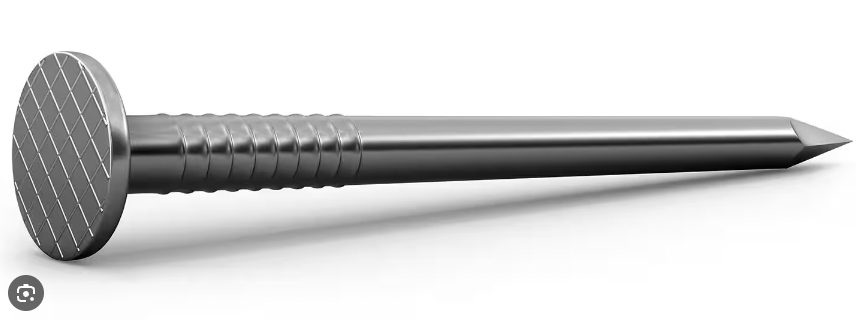

In [8]:
# POC

import numpy as np
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider

def generate_points(length, width, height, num_points):
    return np.random.rand(num_points, 3) * [length, width, height]

def apply_pca(points):
    pca = PCA(n_components=1)
    pca.fit(points)
    return pca

# Redefine adjust_vertices_for_centering function to make sure it's available
def adjust_vertices_for_centering(cuboid_size, cube_size, axis_limit):
    total_length = cuboid_size[0] + cube_size[0]
    offset_x = (axis_limit - total_length) / 2
    offset_y = (axis_limit - max(cuboid_size[1], cube_size[1])) / 2
    offset_z = (axis_limit - max(cuboid_size[2], cube_size[2])) / 2
    
    cuboid_vertices = np.array([
        [offset_x, offset_y, offset_z],
        [offset_x + cuboid_size[0], offset_y, offset_z],
        [offset_x + cuboid_size[0], offset_y + cuboid_size[1], offset_z],
        [offset_x, offset_y + cuboid_size[1], offset_z],
        [offset_x, offset_y, offset_z + cuboid_size[2]],
        [offset_x + cuboid_size[0], offset_y, offset_z + cuboid_size[2]],
        [offset_x + cuboid_size[0], offset_y + cuboid_size[1], offset_z + cuboid_size[2]],
        [offset_x, offset_y + cuboid_size[1], offset_z + cuboid_size[2]],
    ])
    
    cube_vertices = np.array([
        [offset_x + cuboid_size[0], offset_y, offset_z],
        [offset_x + cuboid_size[0] + cube_size[0], offset_y, offset_z],
        [offset_x + cuboid_size[0] + cube_size[0], offset_y + cube_size[1], offset_z],
        [offset_x + cuboid_size[0], offset_y + cube_size[1], offset_z],
        [offset_x + cuboid_size[0], offset_y, offset_z + cube_size[2]],
        [offset_x + cuboid_size[0] + cube_size[0], offset_y, offset_z + cube_size[2]],
        [offset_x + cuboid_size[0] + cube_size[0], offset_y + cube_size[1], offset_z + cube_size[2]],
        [offset_x + cuboid_size[0], offset_y + cube_size[1], offset_z + cube_size[2]],
    ])
    
    return cuboid_vertices, cube_vertices

#############################################################################################################
def create_edges(vertices):
    edges_indices = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
        (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
        (0, 4), (1, 5), (2, 6), (3, 7)   # Side faces
    ]
    edges = []
    for start, end in edges_indices:
        edge = go.Scatter3d(x=[vertices[start][0], vertices[end][0]],
                            y=[vertices[start][1], vertices[end][1]],
                            z=[vertices[start][2], vertices[end][2]],
                            mode='lines', line=dict(color='black', width=2))
        edges.append(edge)
    return edges

def visualize_pca_components(pca, center, points):
    components = pca.components_
    lengths = pca.explained_variance_ratio_ * 10  # Adjust length for visibility
    lines = []
    # Limit the loop to only the first component
    i = 0  # Index for the first principal component
    length = lengths[i]
    vector = components[i]
    start = center
    end = center + vector * length
    line_width = 5  # Make the first component bolder
    color = 'red'  # Color for the first principal component
    
    # Add line for the first PCA component
    lines.append(go.Scatter3d(x=[start[0], end[0]], y=[start[1], end[1]], z=[start[2], end[2]],
                              mode='lines',
                              line=dict(color=color, width=line_width),
                              name=f'PCA {i+1}'))
    
    # Add cone to indicate direction for the first component
    lines.append(go.Cone(x=[end[0]], y=[end[1]], z=[end[2]],
                         u=[vector[0] * length * 0.2], v=[vector[1] * length * 0.2], w=[vector[2] * length * 0.2],
                         showscale=False,
                         colorscale=[[0, color], [1, color]],
                         sizemode="absolute", sizeref=2))
    
    return lines



def update_plot(body_density=100, head_density=50):
    cuboid_size = np.array([6, 1, 1])
    cube_size = np.array([1, 1, 1])
    cuboid_vertices, cube_vertices = adjust_vertices_for_centering(cuboid_size, cube_size, 10)
    
    cuboid_points = generate_points(*cuboid_size, body_density) + cuboid_vertices[0]
    cube_points = generate_points(*cube_size, head_density) + cube_vertices[0]
    
    all_points = np.vstack([cuboid_points, cube_points])
    pca = apply_pca(all_points)
    
    fig = go.Figure(data=[
        go.Scatter3d(x=cuboid_points[:, 0], y=cuboid_points[:, 1], z=cuboid_points[:, 2], mode='markers', name='Cuboid Body', marker=dict(size=2)),
        go.Scatter3d(x=cube_points[:, 0], y=cube_points[:, 1], z=cube_points[:, 2], mode='markers', name='Cube Head', marker=dict(size=2))
    ])
    
    # Add cuboid and cube outlines
    fig.add_traces(create_edges(cuboid_vertices))
    fig.add_traces(create_edges(cube_vertices))
    
    # Add PCA components with arrowheads
    fig.add_traces(visualize_pca_components(pca, all_points.mean(axis=0), all_points))
    
    fig.update_layout(scene=dict(aspectmode='cube'), margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

# Interactive widget
interact(update_plot, body_density=IntSlider(min=50, max=500, step=50, value=100),
         head_density=IntSlider(min=50, max=500, step=50, value=50))


interactive(children=(IntSlider(value=100, description='body_density', max=500, min=50, step=50), IntSlider(va…

<function __main__.update_plot(body_density=100, head_density=50)>